In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
from river.data.dataset import DatasetSVDStrainFDFromSVDWFonGPU, DatasetSVDStrainFDFromSVDWFonGPUBatch
#import river.data.utils as datautils
from river.data.utils import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import glob
import time

In [3]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")

In [4]:
def loadVandVh(Vhfilepath, Nbasis):
    with open(Vhfilepath, 'rb') as f:
        Vh = pickle.load(f)
    if len(Vh)<Nbasis:
        raise ValueError(f'required Nbasis ({Nbasis}) > len(Vh) ({len(Vh)})!')
    Vh = Vh[:Nbasis]
    V = Vh.T.conj()
        
    return V, Vh

In [5]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)


19:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [136]:
minibatch_size = 128
dataset_train = DatasetSVDStrainFDFromSVDWFonGPUBatch(train_filenames[:1], PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, add_noise=False, minibatch_size=minibatch_size)

dataset_valid = DatasetSVDStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, add_noise=False)

In [137]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_length, dim_list):
        super().__init__()
        self.input_length = input_length
        self.dim_list = dim_list
            
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
     
    def make_encoder(self):
        layers = []
        for i,dim in enumerate(self.dim_list):
            if i==0:
                layers.append(torch.nn.Linear(self.input_length, dim))
            else:
                layers.append(torch.nn.Linear(self.dim_list[i-1], dim))
            
            if i!=len(self.dim_list)-1:
                layers.append(torch.nn.ReLU())
                    
        net = nn.Sequential(*layers)
        return net
    
    def make_decoder(self):
        layers = []
        dim_list= self.dim_list[::-1]
        for i,dim in enumerate(dim_list):
            if i!=len(dim_list)-1:
                layers.append(torch.nn.Linear(dim, dim_list[i+1]))
                layers.append(torch.nn.ReLU())
            else:
                layers.append(torch.nn.Linear(dim, self.input_length))
            
                    
        net = nn.Sequential(*layers)
        return net
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [148]:
device = 'cuda'
ae = AutoEncoder(512, [ 256, 128, 64]).to(device)

In [149]:

batch_size_train = 4096
dataloader_train = DataLoader(dataset_train, batch_size=batch_size_train//minibatch_size, shuffle=False)

batch_size_valid = 1000
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size_valid, shuffle=False)

In [150]:
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)



In [151]:
count_parameters(ae)

345408

In [152]:
Nepoch = 5000
comp_index = 0
mean_train_loss = []
mean_valid_loss = []

best_epoch = 0
last_adjust_epoch = 0
best_loss = 1e3

ckpt_file = 'ae.pt'
for epoch in range(Nepoch):
    train_losses = []
    valid_losses = []
    
    ae.train()
    for theta, x_all in dataloader_train:
        x_all = x_all.view(batch_size_train, 6, 512)
        #x = x_all[:,comp_index,:].to(device)
        x = x_all.view(batch_size_train*6, 512)
        optimizer.zero_grad()
        x_pred = ae(x)
        loss = nn.MSELoss()(x_pred, x)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        
    ae.eval()
    with torch.no_grad():
        for theta, x_all in dataloader_valid:
            #x = x_all[:,comp_index,:].to(device)
            x = x_all.view(batch_size_valid*6, 512)
            x_pred = ae(x)
            loss = nn.MSELoss()(x_pred, x)
            valid_losses.append(loss.item())
    
    
    mean_train_loss.append(np.mean(train_losses))
    current_valid_loss = np.mean(valid_losses)
    mean_valid_loss.append(current_valid_loss)
    
    print(f"epoch = {epoch}, train loss: {np.mean(train_losses)}, valid loss: {np.mean(valid_losses)}")
    
    if current_valid_loss < best_loss:
        torch.save(ae.state_dict(), ckpt_file)
        best_loss = current_valid_loss
        best_epoch = epoch
        print(f'    saved best epoch = {best_epoch} to {ckpt_file}')
        
    if (epoch - best_epoch >= 12) and (epoch-last_adjust_epoch>=8):
        adjust_lr(optimizer, 0.7)
        last_adjust_epoch = epoch
        print(f'    lr is decreased by 0.7')
    
    dataset_train.shuffle_indexinfile()
    dataset_train.shuffle_wflist()
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size_train//minibatch_size, shuffle=False)


epoch = 0, train loss: 0.8928236439824104, valid loss: 0.748722493648529
    saved best epoch = 0 to ae.pt
epoch = 1, train loss: 0.7972963508218527, valid loss: 0.6463894248008728
    saved best epoch = 1 to ae.pt
epoch = 2, train loss: 0.7426006812602282, valid loss: 0.8244600892066956
epoch = 3, train loss: 0.7123438771814108, valid loss: 0.6219953298568726
    saved best epoch = 3 to ae.pt
epoch = 4, train loss: 0.7187096271663904, valid loss: 0.656695544719696
epoch = 5, train loss: 0.6817814260721207, valid loss: 0.675920307636261
epoch = 6, train loss: 0.6501189898699522, valid loss: 0.6698622107505798
epoch = 7, train loss: 0.6467886827886105, valid loss: 0.6849702000617981
epoch = 8, train loss: 0.6576886307448149, valid loss: 0.7012557983398438
epoch = 9, train loss: 0.6404106318950653, valid loss: 0.6456117630004883
epoch = 10, train loss: 0.6331321615725756, valid loss: 0.6484184265136719
epoch = 11, train loss: 0.6220603231340647, valid loss: 0.6811482906341553


KeyboardInterrupt: 

In [153]:
for theta, x_all in dataloader_valid:
    pass

In [160]:
import torch.nn.functional as F


In [155]:
x_all.size()[2]

512

In [166]:
x_all.shape

torch.Size([1000, 6, 512])

In [167]:
xx_all = x_all.view(1000, 6*512)

In [172]:
xx_all[0][512]

tensor(0.1529, device='cuda:0')

In [174]:
xxx = x_all.flatten(start_dim=1)

In [176]:
xxx == xx_all

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [171]:
x_all[0]

tensor([[ 2.2624e-01, -4.6614e-01,  1.6094e-01,  ...,  5.0891e-02,
          3.4323e-04,  3.5441e-02],
        [ 1.5290e-01, -7.9519e-01,  1.5922e-01,  ..., -1.1206e-02,
         -4.7445e-02, -1.2334e-03],
        [-3.1746e-02, -1.1505e+00, -5.9565e-01,  ...,  2.0669e-02,
         -1.5867e-01,  6.8913e-03],
        [-8.5699e-01,  3.8290e-01, -7.7084e-01,  ..., -7.0113e-02,
          1.4456e-01, -7.3845e-02],
        [-5.1046e-01,  1.2727e-01, -3.3162e-01,  ...,  6.1358e-02,
         -1.1245e-01,  6.4858e-02],
        [ 6.2513e-01, -7.0240e-01,  6.0801e-01,  ...,  1.6936e-01,
         -2.6677e-01,  1.7227e-01]], device='cuda:0')

In [161]:
a = F.avg_pool1d(x_all, x_all.size()[2])

In [164]:
b = a.view(a.size(0), -1)

In [163]:
a.shape

torch.Size([1000, 6, 1])

In [165]:
b.shape

torch.Size([1000, 6])

In [99]:
ae.load_state_dict(torch.load('ae.pt'))

<All keys matched successfully>

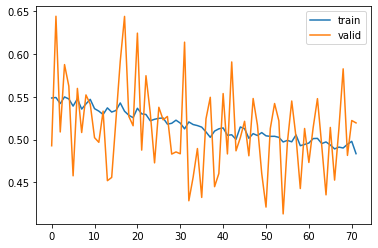

In [102]:
plt.plot(mean_train_loss, label='train')
plt.plot(mean_valid_loss, label='valid')
plt.legend()


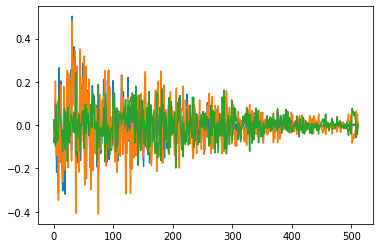

In [103]:
plt.plot(x_pred[0].detach().cpu())
plt.plot(x[0].detach().cpu())
plt.plot(x_pred[0].detach().cpu() - x[0].detach().cpu())

In [62]:
torch.save(ae.state_dict(), 'ae.pt')

In [65]:
adjust_lr??